In [1]:
#Falta añadir ruido y controlar las duraciones, se necesitan 2 segundos (256 pixeles) y frecuencia a 1024Hz (64 pixeles)

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

import pywt
import os
from sklearn.decomposition import PCA
from pathlib import Path

import mne
from mne.datasets import somato
from mne.time_frequency import tfr_morlet

In [23]:

def shift(directory,outdir):
    
    os.makedirs(outdir, exist_ok=True)
    
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            
            data = np.loadtxt(f, delimiter=" ",)
            
            for i in range(4):
                # hacer un shift de 4 posiciones hacia la izquierda
                shift = ( i ) * 4915
                data_shifted = np.roll(data, shift,axis=0)
            
                #print("Array con shift:", data_shifted)
            
                outfile =  outdir + '/' + Path(filename).stem + '_' + str(i) + '.txt'
            
                np.savetxt(outfile, data_shifted, delimiter=' ')
        
    
    
#path = 'data/2000 data'
#shift(path,'data/shift_data')

In [2]:
import numpy as np
from scipy.signal import stft
import matplotlib.pyplot as plt

def calcular_stft(data,sampling_rate = 16384 ,graph=False, fmax=8192):
    # Definir parámetros de la STFT
    
    
    
    longitud_ventana = 2048
    salto_ventana = longitud_ventana // 4
    num_segmentos = 144
    freq_lim = fmax
    
    # Calcular STFT utilizando la función stft de scipy
    f, t, Zxx = stft(data, fs = sampling_rate, window='hann', nperseg=longitud_ventana, noverlap=salto_ventana, nfft=longitud_ventana)
    
    # Recortar la matriz Zxx para llegar a la frecuencia maxima
    
    f_range = (0,freq_lim) # Hz
    freq_slice = np.where((f >= f_range[0]) & (f <= f_range[1]))

    # keep only frequencies of interest
    f   = f[freq_slice]
    Zxx = Zxx[freq_slice,:][0]
    
    if graph:
        
        plt.pcolormesh(t, f, np.abs(Zxx),cmap='twilight', vmax=abs(Zxx).max(), vmin=-abs(Zxx).max())
        plt.title('stft \n freq_lim = ' + str(freq_lim) 
                 )
        plt.xlabel('Time')
        plt.ylabel('Frequency')
        #plt.colorbar()
        plt.show()
    
    return Zxx

# Ejemplo de uso

ruta = 'data/2000 datafull/s11.2--LS220_0.1kpc_sim1.txt'
serie_de_tiempo = np.loadtxt(ruta, delimiter=" ")[:,1]
#
stft_matriz = calcular_stft(serie_de_tiempo, graph=True,
                           fmax = 2046
                           )
#
print("Dimensiones de la STFT:", stft_matriz.shape)



RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

ImportError: numpy.core.multiarray failed to import

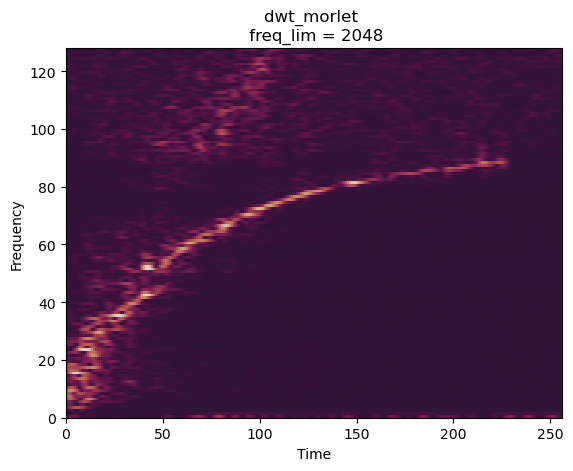

(128, 256)

In [4]:
def dwt_morlet(data,sampling_rate = 16384 ,graph=False, fmax=8192):
    
    data = data.reshape(1,1,len(data))
    
    freqs = np.arange(1,fmax,16) #64 niveles de descomposicion
    
    n_cycles = freqs/8. 
    
    tF = mne.time_frequency.tfr_array_morlet(epoch_data = data , 
                                             sfreq = sampling_rate , 
                                             freqs = freqs , 
                                             n_cycles = n_cycles,
                                             decim = 128,
                                             verbose = False) 
    
    tfr_morlet = tF[0,0,:,:]
    
    if graph:
        plt.pcolormesh(np.abs(tfr_morlet),cmap='twilight', vmax=abs(tfr_morlet).max(), vmin=-abs(tfr_morlet).max())
        
        plt.title('dwt_morlet \n freq_lim = ' + str(fmax)
                 )
        plt.xlabel('Time')
        plt.ylabel('Frequency')
        
        plt.show()
    return tfr_morlet
ruta = 'data/2000 datafull/s11.2--LS220_0.1kpc_sim234.txt'
data = np.loadtxt(ruta, delimiter=" ",)[:,1]
dwt_morlet(data,
           graph = True,
             fmax = 2048
                 ).shape

In [2]:
import librosa
import librosa.display

#utilizar en otro env, librosa choca con algunas libs

def mel(data,sampling_rate = 16384 ,graph=False, fmax=8192):
    

    n_fft=2024
    hop_length=64#512
    n_mels=40#128
    
    
    S = librosa.feature.melspectrogram(y=data, 
                                       sr=sampling_rate, 
                                       n_fft=n_fft, 
                                       hop_length=hop_length,
                                       fmax=fmax, #En el paper de Astone se utiliza un limite de 1024
                                       n_mels=n_mels
                                      )
    if graph:
        
        librosa.display.specshow(S, sr=sampling_rate, hop_length=hop_length, x_axis='time', y_axis='mel',cmap='twilight', vmax=abs(S).max(), vmin=-abs(S).max())
        plt.title('melspectrogram \n freq_lim = ' + str(fmax) 
                 )
        plt.xlabel('Time')
        plt.ylabel('Frequency')
        
        plt.show()
        
    return S
ruta = 'data/2000 datafull/s11.2--LS220_0.1kpc_sim1.txt'
data = np.loadtxt(ruta, delimiter=" ",)[:,1]
mel(data,graph=True,
     #fmax=1024
    ).shape


ModuleNotFoundError: No module named 'librosa'

In [69]:
import tftb
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

def el_diablo(data,sampling_rate = 16384 ,graph=False, fmax=8192):
    '''
        me mata el pc correr esto, la se;al es muy grande por lo que la funcion se hace muy pesada en memoria
    '''
    
    
    #signal = signal[0:15000]
    
    #new_sampling_rate = 1024
    #signal = sig.resample(signal, 2*new_sampling_rate)
    
    T = 2
    # signal duration
    dt = 1/sampling_rate  # sample interval/spacing
    N = T / dt  # number of samples
    ts = np.arange(N) * dt  # times
    
    
    #  plotting the signal
    #plt.figure()
    #plt.plot(ts, signal)
    #plt.show()
    
    
    
    
    # Doing the WVT
    wvd = tftb.processing.WignerVilleDistribution(data, timestamps=ts)
    tfr_wvd, t_wvd, f_wvd = wvd.run()
    
    # here t_wvd is the same as our ts, and f_wvd are the "normalized frequencies"
    # so we will not use them and construct our own
    #f_wvd = np.fft.fftshift(np.fft.fftfreq(tfr_wvd.shape[0], d=2 * dt))
    #df_wvd = f_wvd[1]-f_wvd[0]
    
    im = plt.imshow(np.fft.fftshift(abs(tfr_wvd), axes=0), vmax=abs(tfr_wvd).max(), vmin=-abs(tfr_wvd).max(),
                 #   extent=(ts[0] - dt/2, 
                 #           ts[-1] + dt/2,
                 #           f_wvd[0]-df_wvd/2, 
                 #           f_wvd[-1]+df_wvd/2),
                    cmap='twilight', aspect='auto', origin='lower')
    plt.ylabel('frequency [Hz]')
    plt.xlabel('time [s]')
    plt.show()
    tfr_wvd.shape

#ruta = 'data/2000 datafull/s11.2--LS220_0.1kpc_sim1.txt'
    
#signal = np.loadtxt(ruta, delimiter=" ",)[:,1]
    
#el_diablo(signal)

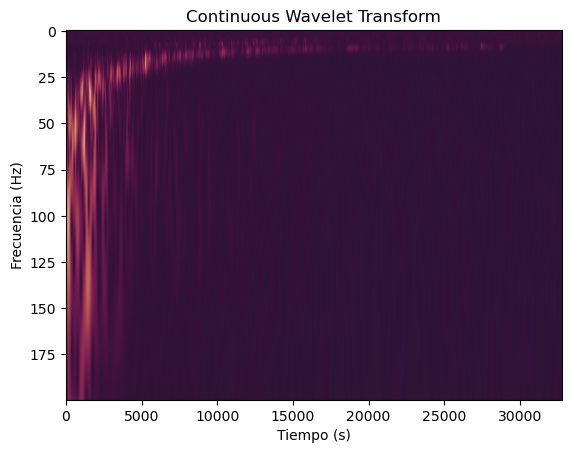

(200, 32768)

In [70]:
### import numpy as np
import matplotlib.pyplot as plt
import pywt

from scipy import signal
from scipy import optimize

#arreglar
def cwt(data,sampling_rate = 16384 ,graph=False, fmax=8192):
    """
    Esta función toma una serie de tiempo y plotea su Continuous Wavelet Transform (CWT) usando scipy.

    Parámetros:
        x (array): la serie de tiempo.
        sampling_rate (float): la frecuencia de muestreo de la serie de tiempo.

    Retorna:
        None.
    """

    widths = np.arange(1, 201)
    
    cwtmatr = signal.cwt(data, signal.morlet2, widths)

    # Visualizar la CWT
    plt.imshow(abs(cwtmatr), cmap = 'twilight', aspect = 'auto', interpolation = 'bilinear' ,
               
               #extent=[0, 2, 0,cwtmatr.shape[0]],
               #origin = 'lower',
               vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max(),
              )
    
    plt.title('Continuous Wavelet Transform')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Frecuencia (Hz)')
    #plt.colorbar()
    plt.show()
    return cwtmatr
    
ruta = 'data/2000 datafull/s11.2--LS220_0.1kpc_sim1.txt'
data = np.loadtxt(ruta, delimiter=" ",)[:,1]
cwt(data).shape

In [42]:
import ewtpy

def ewt(data,sampling_rate = 16384 ,graph=False, fmax=8192):
    """
    Esta función toma una serie de tiempo y plotea su Continuous Wavelet Transform (CWT).

    Parámetros:
        x (array): la serie de tiempo.
        sampling_rate (float): la frecuencia de muestreo de la serie de tiempo.

    Retorna:
        None.
    """
    
    #t = np.arange(0, 2, 1/100)
    #x = np.sin(2*np.pi*10*t) + np.sin(2*np.pi*20*t) + np.sin(2*np.pi*30*t)
    #sampling_rate = 10
    
    # Calcular la CWT
    ewt, mfb ,boundaries = ewtpy.EWT1D(data, 
                                 N = 5, 
                                 log = 0,
                                 detect = "locmax", 
                                 completion = 0, 
                                 reg = 'average', 
                                 lengthFilter = 10,
                                 sigmaFilter = 5)

    # Visualizar la CWT
    #plt.imshow(abs(ewt), cmap='coolwarm', aspect='auto', origin='lower',
    #           #extent=[0, len(x)/sampling_rate, freqs[-1], freqs[0]]
    #          )
    
    if graph:
        fig, ax = plt.subplots(ewt.shape[1],1)
        fig.tight_layout()
        ax[0].set_title('Empirical Wavelet Transform')
        
        for i in range(ewt.shape[1]):
            ax[i].plot(ewt[:,i])
            #ax[i].set_ylabel('(Hz)')
        
        ax[ewt.shape[1]-1].set_xlabel('Tiempo (s)')
        
        #plt.colorbar()
        plt.show()
        
        
    return ewt 
    
ruta = 'data/2000 datafull/s11.2--LS220_0.1kpc_sim1.txt'
#ruta = 'data/2000 datafull/aLIGO_noise_2sec_sim1.txt'

x = np.loadtxt(ruta, delimiter=" ",)[:,1]

e = ewt(x)

#dwt_morlet(e[:,0],graph = True, 
##               fmax = 1024
#                ).shape
#dwt_morlet(e[:,1],graph = True, 
##               fmax = 1024
#                ).shape
#dwt_morlet(e[:,2],graph = True, 
##               fmax = 1024
#                ).shape
#dwt_morlet(e[:,3],graph = True, 
##               fmax = 1024
#                ).shape


In [72]:
'''
T = 1000
t = np.arange(1,T+1)/T
f = np.cos(2*np.pi*0.8*t) + 2*np.cos(2*np.pi*10*t)+0.8*np.cos(2*np.pi*100*t)
ewt,  mfb ,boundaries = ewtpy.EWT1D(f, N = 3)
plt.plot(f)
plt.show()
plt.plot(ewt)
plt.show()
'''

'\nT = 1000\nt = np.arange(1,T+1)/T\nf = np.cos(2*np.pi*0.8*t) + 2*np.cos(2*np.pi*10*t)+0.8*np.cos(2*np.pi*100*t)\newt,  mfb ,boundaries = ewtpy.EWT1D(f, N = 3)\nplt.plot(f)\nplt.show()\nplt.plot(ewt)\nplt.show()\n'

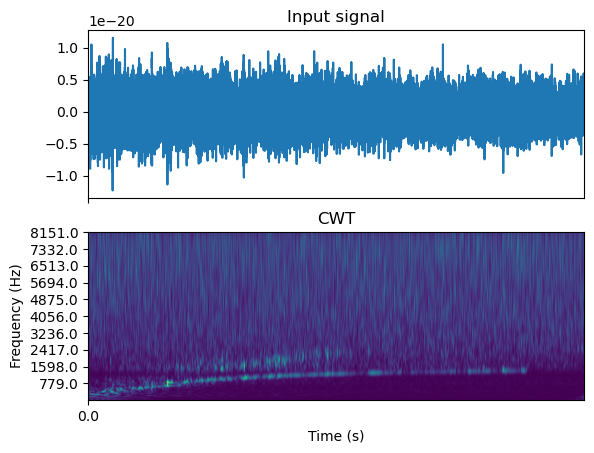

(200, 32768)

In [73]:
import fcwt
import numpy as np
import matplotlib.pyplot as plt

def calcular_fcwt(data,sampling_rate = 16384 ,graph=False, fmax=8192):
    #Initialize
    fs = 16384
    n = fs*2 #2 seconds
    ts = np.arange(n)
    
    f0 = 1 #lowest frequency
    f1 = fmax #highest frequency
    fn = 200 #number of frequencies
    
    #Calculate CWT without plotting...
    freqs, out = fcwt.cwt(signal, fs, f0, f1, fn)
    
    
    if graph:
        #... or calculate and plot CWT
        fcwt.plot(signal, fs, f0=f0, f1=f1, fn=fn)
        
    
    return out


ruta = 'data/2000 datafull/s11.2--LS220_0.1kpc_sim1.txt'
#ruta = 'data/2000 datafull/aLIGO_noise_2sec_sim1.txt'

signal = np.loadtxt(ruta, delimiter=" ",)[:,1]

calcular_fcwt(signal,graph=True).shape

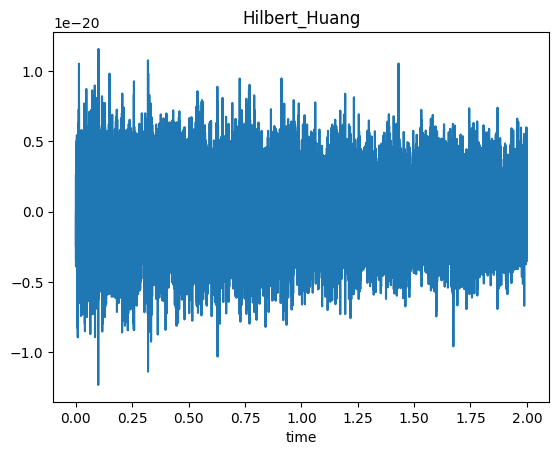

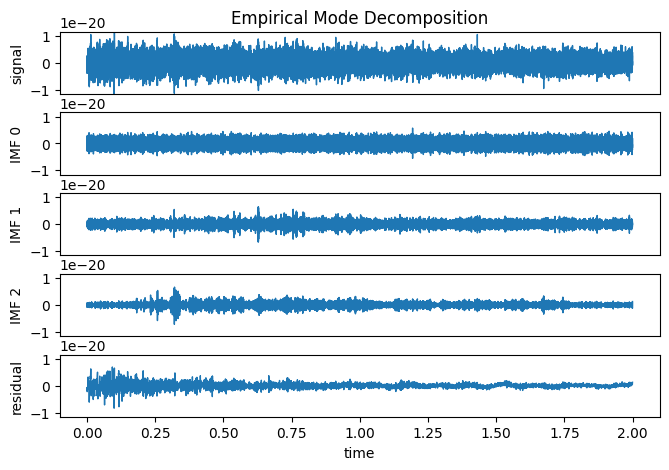

In [5]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from torchHHT import hht, visualization
from scipy.signal import chirp
import IPython

def Hilbert_Huang(data,sampling_rate = 16384 ,graph=False, fmax=8192):
    
    fs = sampling_rate
    #fs = 1000
    duration = 2.0
    t = torch.arange(fs*duration) / fs
    #x = torch.from_numpy(chirp(t, 5, 0.8, 10, method = "quadratic", phi=100)) * torch.exp(-4*(t-1)**2) + \
    #    torch.from_numpy(chirp(t, 40, 1.2, 50, method = "linear")) * torch.exp(-4*(t-1)**2)
    
    x = data
    
    
    plt.plot(t, x) 
    plt.title("Hilbert_Huang")
    plt.xlabel("time")
    plt.show()
    
    #descomposition
    imfs, imfs_env, imfs_freq = hht.hilbert_huang(x, fs, num_imf=3)
    visualization.plot_IMFs(x, imfs, fs)
    
    #spectrum, t, f = hht.hilbert_spectrum(imfs_env, imfs_freq, fs, freq_lim = (0, fmax), time_scale=1, freq_res = 1)
    #visualization.plot_HilbertSpectrum(spectrum, t, f)
    
    return

ruta = 'data/2000 datafull/s11.2--LS220_0.1kpc_sim1.txt'
#ruta = 'data/2000 datafull/aLIGO_noise_2sec_sim1.txt'

signal = np.loadtxt(ruta, delimiter=" ",)[:,1]

Hilbert_Huang(signal,graph=True)



In [59]:
# Preproceso de datos usando MNE
def preprocesar_dir(directory, outdir, trns_indx = 0, graph=False, white=False, pad=0, fmax = 8192, verbose = 0):
    
    
    trns_funct = [calcular_stft,dwt_morlet, cwt, calcular_fcwt]
    trns_names = ['STFT','DWT_Morlet','CWT','fCWT']
    
    outdir = outdir + trns_names[trns_indx]
    
    if verbose:
        print("Processing " + trns_names[trns_indx])
        print("--------------------------")
        print("dir_input: ", directory)
        print("dir_output: ", outdir)
        print("fmax: ", fmax, " Hz")
        filename = os.listdir(directory)[0]
        dataTransformed = trns_funct[trns_indx](os.path.join(directory, filename),graph=False , fmax = fmax)
        print("shape outdata: ", dataTransformed.shape)
        print("dtype outdata: ", dataTransformed.dtype)
        print("--------------------------")
          
    
    os.makedirs(outdir, exist_ok=True)
   
    for filename in tqdm(os.listdir(directory)):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            dataTransformed = trns_funct[trns_indx](f,graph=False , fmax = fmax)
            dataTransformed = abs(dataTransformed)
            
            outfile =  outdir + '/' + Path(filename).stem + '.txt'
            
            #np.savetxt(outfile, dataTransformed, delimiter=',')
            

In [60]:
preprocesar_dir('data/2000 datafull','data/', trns_indx = 0 , fmax = 2048, verbose = 1) #STFT
preprocesar_dir('data/2000 datafull','data/', trns_indx = 1 , fmax = 2048, verbose = 1) #DWT Morlet
preprocesar_dir('data/2000 datafull','data/', trns_indx = 2 , fmax = 2048, verbose = 1) #cwt
preprocesar_dir('data/2000 datafull','data/', trns_indx = 3 , fmax = 2048, verbose = 1) #fcwt

Processing STFT
--------------------------
dir_input:  data/2000 datafull
dir_output:  data/STFT
fmax:  1024  Hz
shape outdata:  (129, 23)
dtype outdata:  complex128
--------------------------


  0%|          | 0/8000 [00:00<?, ?it/s]

Processing DWT_Morlet
--------------------------
dir_input:  data/2000 datafull
dir_output:  data/DWT_Morlet
fmax:  1024  Hz
shape outdata:  (64, 256)
dtype outdata:  complex128
--------------------------


  0%|          | 0/8000 [00:00<?, ?it/s]

Processing MelSpectrograms
--------------------------
dir_input:  data/2000 datafull
dir_output:  data/MelSpectrograms
fmax:  8192  Hz
shape outdata:  (40, 513)
dtype outdata:  float64
--------------------------


  0%|          | 0/8000 [00:00<?, ?it/s]